<a href="https://colab.research.google.com/github/santule/ERA/blob/main/S18P2/mnist_cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install pytorch-lightning==2.0.1 --quiet
! pip install lightning-bolts --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning-bolts 0.7.0 requires pytorch-lightning<2.0.0,>1.7.0, but you have pytorch-lightning 2.0.1 which is incompatible.


In [4]:
import torch
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
# from pl_bolts.models.autoencoders.components import (
#     resnet18_decoder,
#     resnet18_encoder,
# )

from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
import torchvision.transforms as T
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import CSVLogger
import pandas as pd
import seaborn as sn

# 1- Define Model

In [27]:
class VAE(pl.LightningModule):
  def __init__(self,enc_out_dim=32, latent_dim=256, featureDim=64*24*24):

    super().__init__()

    self.save_hyperparameters()
    # encoder layers
    self.encConv1 = nn.Conv2d(2,32,3)
    self.encConv2 = nn.Conv2d(32,64,3)
    self.fc_mu = nn.Linear(featureDim,latent_dim)
    self.fc_var = nn.Linear(featureDim, latent_dim)

    # decoder layers
    self.deFC1 = nn.Linear(latent_dim + 10, featureDim)
    self.deConv1 = nn.ConvTranspose2d(64,32,3)
    self.deConv2 = nn.ConvTranspose2d(32,1,3)

    self.log_scale = nn.Parameter(torch.Tensor([0.0]))

  def encoder(self,x,y):
    # add label to image
    y = F.one_hot(y, num_classes = x.shape[2]).unsqueeze(1).unsqueeze(2) # one hot y
    y = torch.ones(x.shape).to('cuda') * y
    t = torch.cat((x,y),dim=1)
    x = F.relu(self.encConv1(t))
    x = F.relu(self.encConv2(x))
    batch_size = x.shape[0]
    x = x.view(batch_size,-1)
    return x

  def decoder(self,z,y):
    y = F.one_hot(y, num_classes = 10)
    z = torch.cat((z, y), dim=1) # b, 256 + 10
    x_hat = F.relu(self.deFC1(z))
    x_hat = x_hat.view(-1,64,24,24)
    x_hat = F.relu(self.deConv1(x_hat))
    x_hat = torch.sigmoid(self.deConv2(x_hat))
    return x_hat

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=1e-4)

  def kl_divergence(self,z,mu,std):
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    kl = (log_qzx - log_pz)
    kl = kl.sum(-1)
    return kl

  def gaussian_likelihood(self,mean,logscale,sample):
    scale   = torch.exp(logscale)
    dist    = torch.distributions.Normal(mean,scale)
    log_pxz = dist.log_prob(sample)
    return log_pxz.sum(dim=(1,2,3))


  def forward(self,x,y):
    x_encoded = self.encoder(x,y)

    mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu,std)
    z = q.rsample()

    x_hat = self.decoder(z,y)
    return x_hat

  def training_epoch_end(self,outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        print("****Training****")
        print(f'Epoch {self.current_epoch}: Train loss {loss}')

  def training_step(self,batch,batch_idx):
    x, y = batch # y - 2,3,4..
    x_encoded   = self.encoder(x.to('cuda'),y.to('cuda'))
    mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

    std = torch.exp(log_var/2)
    q = torch.distributions.Normal(mu,std)
    z = q.rsample()

    x_hat = self.decoder(z,y.to('cuda'))

    recon_loss = self.gaussian_likelihood(x_hat,self.log_scale,x)
    kl = self.kl_divergence(z,mu,std)
    elbo = kl - recon_loss
    elbo = elbo.mean()

    # recon_loss = F.mse_loss(x_hat, x, reduction='sum')
    # kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    # elbo = kl + recon_loss
    # elbo = elbo.mean()

    self.log_dict({
        'elbo': elbo,
        'kl': kl.mean(),
        'recon_loss': recon_loss.mean(),
        'reconstruction': recon_loss.mean(),
        'kl': kl.mean(),
    })
    return elbo

In [28]:
# check the dimensions of the vae
my_vae_check = VAE().to('cuda')
print(my_vae_check)

x = torch.rand(1,1,28,28).to('cuda')
y = torch.tensor(1).unsqueeze(0).to('cuda')
my_vae_check(x,y).shape

VAE(
  (encConv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (encConv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc_mu): Linear(in_features=36864, out_features=256, bias=True)
  (fc_var): Linear(in_features=36864, out_features=256, bias=True)
  (deFC1): Linear(in_features=266, out_features=36864, bias=True)
  (deConv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (deConv2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1))
)


torch.Size([1, 1, 28, 28])

# 2 - Data

In [29]:
transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)),
                                  ])

dataset = MNIST(root='data',train=True,transform=transform ,download=True) # transforms.ToTensor()
train_dataloader = DataLoader(dataset = dataset, batch_size=32,shuffle=True)

dataset_test = MNIST(root='data',train=False,transform=transform, download=True) # transforms.ToTensor()
test_dataloader = DataLoader(dataset = dataset_test, batch_size=32,shuffle=False)

In [30]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

# 3 - Train Model

In [42]:
pl.seed_everything(1234)
my_vae = VAE().to('cuda')
trainer = pl.Trainer(gpus=1, max_epochs=30, logger= [CSVLogger(save_dir="logs/")],)
trainer.fit(my_vae,train_dataloader ,test_dataloader)

INFO:lightning_fabric.utilities.seed:Global seed set to 1234
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
INFO:pytorch_lightni

Training: 0it [00:00, ?it/s]

****Training****
Epoch 0: Train loss 967.7296752929688
****Training****
Epoch 1: Train loss 910.2069702148438
****Training****
Epoch 2: Train loss 896.5488891601562
****Training****
Epoch 3: Train loss 890.0930786132812
****Training****
Epoch 4: Train loss 886.3194580078125
****Training****
Epoch 5: Train loss 883.8613891601562
****Training****
Epoch 6: Train loss 881.9108276367188
****Training****
Epoch 7: Train loss 880.4132690429688
****Training****
Epoch 8: Train loss 879.0781860351562
****Training****
Epoch 9: Train loss 877.94921875
****Training****
Epoch 10: Train loss 876.99365234375
****Training****
Epoch 11: Train loss 876.0953369140625
****Training****
Epoch 12: Train loss 875.2384033203125
****Training****
Epoch 13: Train loss 874.5013427734375
****Training****
Epoch 14: Train loss 873.81494140625
****Training****
Epoch 15: Train loss 873.2578735351562
****Training****
Epoch 16: Train loss 872.6658935546875
****Training****
Epoch 17: Train loss 872.2007446289062
****Trainin

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


,elbo,kl,recon_loss,reconstruction
epoch,,,,
0,1166.156006,3.145691,-1163.010376,-1163.010376
0,1118.819702,20.697918,-1098.121826,-1098.121826
0,1040.011841,9.823760,-1030.188110,-1030.188110
0,1031.277832,18.514566,-1012.763245,-1012.763245
0,1002.678162,19.161186,-983.516968,-983.516968
...,...,...,...,...
10,893.814331,30.553579,-863.260742,-863.260742
10,870.626221,32.669346,-837.956970,-837.956970
10,852.940674,34.875557,-818.065186,-818.065186


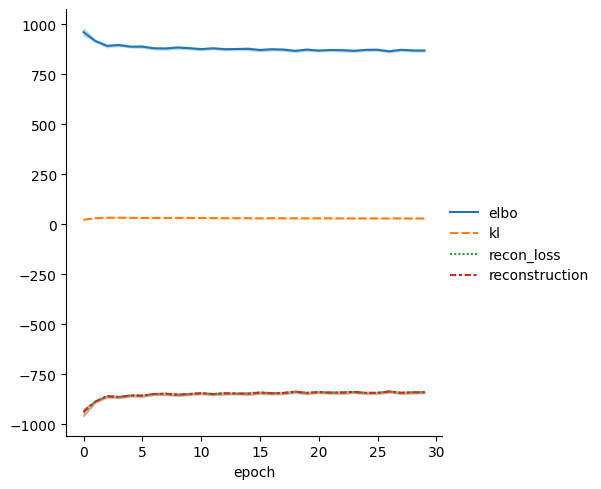

In [43]:
# training log plots
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head(400))
sn.relplot(data=metrics, kind="line")

In [32]:
# mean become -ve, so the recon losss becomes big +ve number, which causes ELBO to be -ve
# dist    = torch.distributions.Normal(3.2605e-03,0.3601)
# dist.log_prob(torch.tensor(0.0004))

# 4 - Plot Images

In [46]:
# plot images
def generate_image(x, y, wrong_y, model,num_predictions=25):
    figure(figsize=(8, 3), dpi=300)
    t2img = T.ToPILImage()

    with torch.no_grad():

        x_encoded   = model.encoder(x.to('cuda'),wrong_y.to('cuda'))
        mu, log_var = model.fc_mu(x_encoded), model.fc_var(x_encoded)

        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()

        x_hat = model.decoder(z,wrong_y.to('cuda'))

        fig = plt.figure(figsize=(10,10))

        for idx in np.arange(num_predictions):

          ax = fig.add_subplot(5,5,idx + 1,xticks=[],yticks=[])
          img = x_hat[idx].to('cpu')
          plt.imshow(img.permute(1,2,0))
          ax.set_title(f"Label/Image: {wrong_y[idx]} / {y[idx]}")

        fig.tight_layout()
        plt.show()

        #img = make_grid(x_hat, nrow=8)
        #plt.imshow(t2img(make_grid(x_hat, nrow=8)), interpolation='nearest')

<Figure size 2400x900 with 0 Axes>

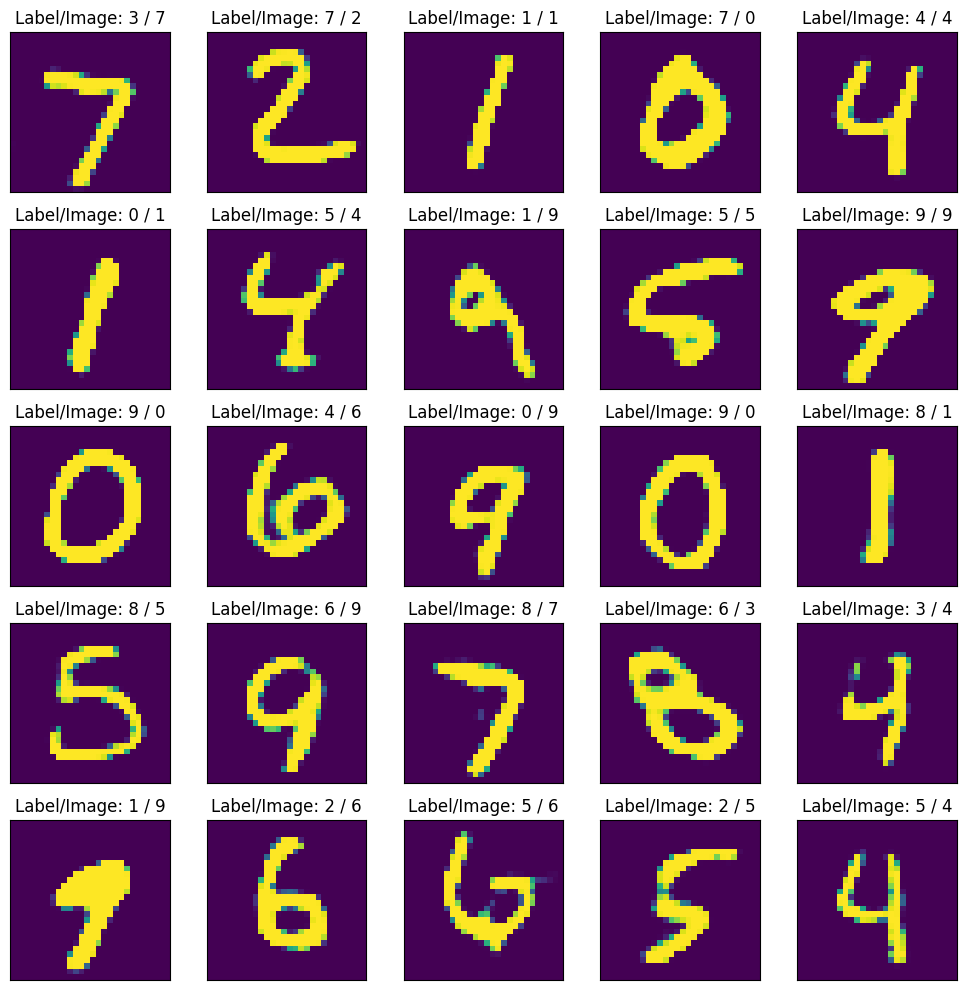

In [47]:
x, y = next(iter(test_dataloader))
wrong_y = torch.tensor(np.random.choice(10,size = 32))
generate_image(x,y,wrong_y,my_vae.to('cuda'))